In [10]:
import random
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from src.lfgp import LFGP
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

%matplotlib inline

In [11]:
# Generate label set
import numpy as np

# Create a list containing the specified number of each integer
numbers = [0] * 60 + [1] * 60 + [2] * 60 + [3] * 60

# Shuffle the list randomly
np.random.shuffle(numbers)

# Update the output format to include indices similar to the dog_label.txt
indexed_numbers = enumerate(numbers)
formatted_data = '\n'.join(f"{index}\t{number}" for index, number in indexed_numbers)

# Write the formatted data to a text file
indexed_output_path = 'label.txt'
with open(indexed_output_path, 'w') as file:
    file.write(formatted_data)

indexed_output_path


'label.txt'

In [74]:
import numpy as np

model = LFGP(lf_dim=3, n_worker_group=4, lambda1=1, lambda2=1)

# Define a function to simulate the entire labeling process
def simulate_labeling(reward_matrix, iterations, worker_types, job_types, worker_label, num_jobs):
    num_workers = len(worker_label)
    # Store labels obtained by each worker after each iteration
    worker_labels = {worker: [] for worker in range(240)}
    
    # Store the number of successful matches in each iteration
    success_counts = []

    best_acc = 0  # Initialize the highest accuracy to 0
    best_pred_label = np.zeros((240, 2))
    
    # Perform iterations
    for i in range(iterations):
        # Randomly generate the number of job types, ensuring the total is num_jobs
        job_counts = np.random.multinomial(num_jobs, [1/len(job_types)]*len(job_types))
        # Generate job type array
        jobs = np.hstack([[wt] * wc for wt, wc in zip(worker_types, job_counts)])
        np.random.shuffle(jobs)  # Shuffle the worker type array

        # Record the number of successful matches in each iteration
        success_count = 0
        
        # First iteration randomly matches, subsequently matches based on previous predictions
        # Choose the worker type to prioritize based on iteration number
        if i < 9:
            # Choose the worker type to prioritize based on iteration number
            if i < 3:
                priority_type = 0
            elif 2 < i < 6:
                priority_type = 1
            elif 5 < i < 9:
                priority_type = 2
            else:
                priority_type = None

            # Select 240 workers of the corresponding type
            priority_jobs = jobs[jobs == priority_type][:num_jobs]
            other_jobs = jobs[jobs != priority_type][:num_jobs - len(priority_jobs)]
            selected_jobs = np.concatenate((priority_jobs, other_jobs))

            for worker in range(num_workers):
                worker_type = worker_label[worker][1]
                job_type = selected_jobs[worker]

                # Calculate the probability of a successful match
                success_prob = reward_matrix[worker_type][job_type]
                match_success = np.random.rand() < success_prob
                # If the match is successful, label with the type with the highest probability
                if match_success:
                    success_count += 1
                    label = np.argmax(reward_matrix[:, job_type])
                else:
                    # If the match fails, label with another type based on the failure probability
                    fail_probs = 1 - reward_matrix[:, job_type]
                    fail_probs[worker_type] = 0  # Set the failure probability of the current type to 0 as it cannot be chosen again
                    label = np.random.choice(worker_types, p=fail_probs/fail_probs.sum())
                # Add the label to the corresponding job
                worker_labels[worker].append(label)
        else:
            # Match each job
            for worker in range(num_workers):
                worker_type = worker_label[worker][1]
                # Get the previous prediction label for the worker
                # pred_label = job_labels[job][-1]
                pred_label1 = int(best_pred_label[worker][1])
                # Get the job type corresponding to the label
                job_type = np.argmax(A[pred_label1])
                # Find the list of workers of that type
                available_jobs = [idx for idx, wt in enumerate(jobs) if wt == job_type]
                # If all workers of that type are already matched, randomly match
                if len(available_jobs) == 0:
                    available_jobs = list(range(num_workers))
                # worker = np.random.choice(available_workers)
                # Calculate the probability of a successful match
                success_prob = reward_matrix[worker_type][job_type]
                # Perform the match and decide if it is successful
                match_success = np.random.rand() < success_prob
                # If the match is successful, label with the type with the highest probability
                if match_success:
                    success_count += 1
                    label = np.argmax(reward_matrix[:, job_type])
                else:
                    # If the match fails, label with another type based on the failure probability
                    fail_probs = 1 - reward_matrix[:, job_type]
                    fail_probs[worker_type] = 0  # Set the failure probability of the current type to 0 as it cannot be chosen again
                    label = np.random.choice(worker_types, p=fail_probs/fail_probs.sum())
                # Add the label to the corresponding job
                worker_labels[worker].append(label)
        
        # Write the label data to a file
        formatted_data = []
        for subject, ratings in worker_labels.items():
            for item_index, rating in enumerate(ratings):
                formatted_data.append(f"{subject}\t{item_index}\t{rating}\n")
        
        # File path
        file_path = 'rating.txt'

        # Write to a text file
        with open(file_path, 'w') as file:
            file.writelines(formatted_data)

        if 7 < i < 9:
            rating = np.loadtxt("rating.txt")
            label = np.loadtxt("label.txt")

            print("number of tasks: {0}".format(len(np.unique(rating[:, 0]))))
            print("number of workers: {0}".format(len(np.unique(rating[:, 1]))))
            print("number of crowd labels: {0}".format(len(rating[:, 0])))

            model._prescreen(rating)

            for seed in range(3):
                np.random.seed(seed)  # Fix the random seed for reproducibility
                model._mc_fit(rating, epsilon=1e-4, maxiter=50)
                pred_label = model._mc_infer(rating)

                acc = np.mean(np.equal(label[:, 1], pred_label[:, 1]))
                if acc > best_acc:  # Check if a new highest accuracy is found
                    best_acc = acc  # Update the highest accuracy
                    best_pred_label = pred_label  # Update the corresponding best predicted labels

            print("Maximum accuracy across all trials:", best_acc)

        # Add the number of successful matches to the list
        success_counts.append(success_count)
        
    return worker_labels, success_counts

# Set reward matrix
A = np.array([[0.9, 0.5, 0.8, 0],
              [0.6, 0.9, 0.4, 0],
              [0.3, 0.8, 0.7, 0],
              [0.7, 0.6, 0.9, 0]])

# Set worker types and job types
worker_types = [0, 1, 2, 3]  # Worker types
job_types = [0, 1, 2, 3]  # Job types
num_jobs = 5000  # Number of jobs
iterations = 30  # Number of iterations

worker_label = np.loadtxt('label.txt', dtype=int)
# Run simulation
worker_labels, success_counts = simulate_labeling(A, iterations, worker_types, job_types, worker_label, num_jobs)

# Display the number of successful matches in each iteration
print(success_counts)


number of tasks: 240
number of workers: 9
number of crowd labels: 2160
Maximum accuracy across all trials: 0.45416666666666666
[155, 152, 163, 173, 161, 177, 175, 166, 166, 194, 196, 186, 169, 181, 178, 180, 191, 184, 186, 190, 185, 169, 196, 175, 178, 179, 192, 180, 182, 191]


In [73]:
model = LFGP(lf_dim=3, n_worker_group=4, lambda1=1, lambda2=1)

best_acc = 0  # Initialize the highest accuracy to 0
best_pred_label = np.zeros((240, 2))

rating = np.loadtxt("rating.txt")
label = np.loadtxt("label.txt")

print("number of tasks: {0}".format(len(np.unique(rating[:, 0]))))
print("number of workers: {0}".format(len(np.unique(rating[:, 1]))))
print("number of crowd labels: {0}".format(len(rating[:, 0])))

model._prescreen(rating)

for seed in range(3):
    np.random.seed(seed)  # Fix the random seed for reproducibility
    model._mc_fit(rating, epsilon=1e-4, maxiter=50)
    pred_label = model._mc_infer(rating)

    acc = np.mean(np.equal(label[:, 1], pred_label[:, 1]))
    if acc > best_acc:  # Check if a new highest accuracy is found
        best_acc = acc  # Update the highest accuracy
        best_pred_label = pred_label  # Update the corresponding best predicted labels

print("Maximum accuracy across all trials:", best_acc)

number of tasks: 240
number of workers: 12
number of crowd labels: 2880
Maximum accuracy across all trials: 0.475


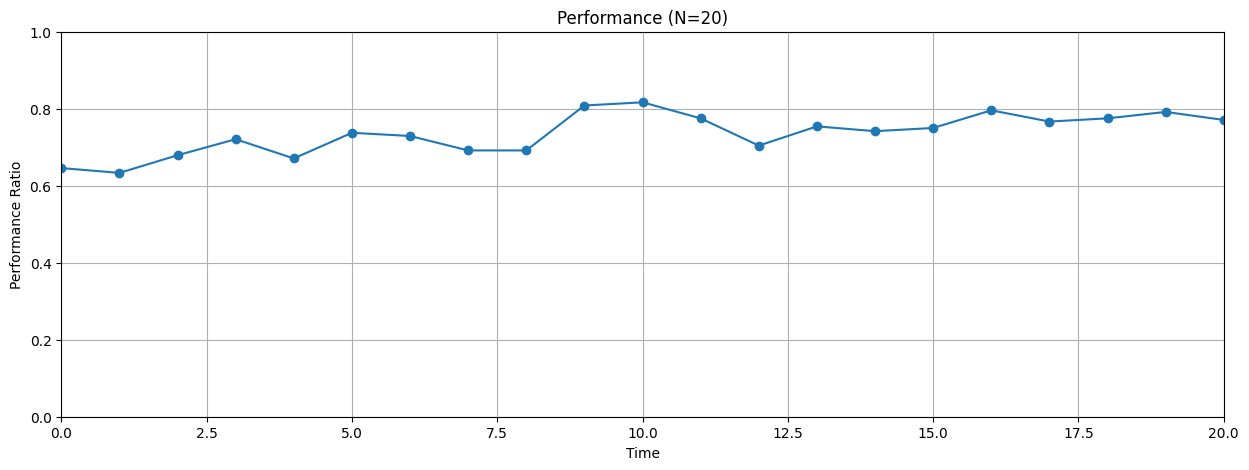

In [76]:
import matplotlib.pyplot as plt

# Divide each element by 240
scaled_data = [x / 240 for x in success_counts]

# Plot line chart
plt.figure(figsize=(15, 5))  # Set figure size
plt.plot(scaled_data, marker='o')  # Plot lines and points
plt.title('Performance (N=20)')  # Title of the chart
plt.xlabel('Time')  # X-axis label
plt.ylabel('Performance Ratio')  # Y-axis label
plt.grid(True)  # Show grid

plt.xlim(0, 20)  # Set x-axis range, assuming you have 20 data points
plt.ylim(0, 1)  # Set y-axis range, estimated based on the minimum and maximum values after dividing by 240

plt.show()  # Display the chart